# Seawater Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

## Data

In [2]:
Hodell1991 = pd.read_csv('Data/Hodell1991a_supplement.csv')
Hodell1994 = pd.read_csv('Data/Hodell1994a_supplement.csv')
Oslick1994 = pd.read_csv('Data/Oslick1994a_supplement.csv')
Peucker1995 = pd.read_csv('Data/Peucker-Ehrenbrink1995a_supplement.csv')
Ravizza1993 = pd.read_csv('Data/Ravizza1993a_supplement.csv')
Reusch1998 = pd.read_csv('Data/Reusch1998a_supplement.csv')

In [3]:
# ratio to convert from 187Os/186Os to 187Os/188Os
Os_conversion_ratio = 0.12035

Hodell1991_age = Hodell1991['Age [Ma]']
Hodell1991_Sr = Hodell1991['87Sr/86Sr']

Hodell1994_age = Hodell1994['Age [Ma]']
Hodell1994_Sr = Hodell1994['87Sr/86Sr']

Oslick1994_age = Oslick1994['Age_b [Ma]']
Oslick1994_Sr = Oslick1994['87Sr/86Sr']

Peucker1995_age = Peucker1995['Age [ka BP]']/1000
Peucker1995_Os = Peucker1995['187Os/188Os']

Ravizza1993_age = Ravizza1993['Age [ka BP]']/1000
Ravizza1993_Os = Ravizza1993['187Os/186Os'] * Os_conversion_ratio

Reusch1998_age = Reusch1998['Age [Ma]']
Reusch1998_Os = Reusch1998['187Os/188Os']

Ignore the Peucker et al. (1995) data for now, since their leaching procedure produces highly variable results.

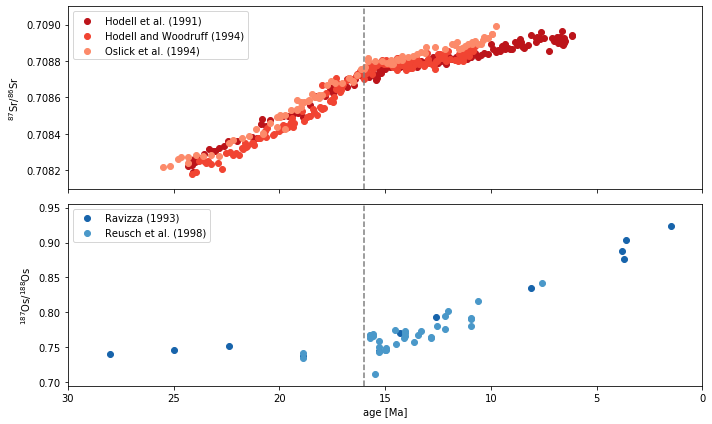

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)

# Sr
Sr_cmap = get_cmap('Reds')

ax[0].scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.8)], label='Hodell et al. (1991)')

ax[0].scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.6)], label='Hodell and Woodruff (1994)')

ax[0].scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

# Os
Os_cmap = get_cmap('Blues')

ax[1].scatter(Ravizza1993_age, Ravizza1993_Os,
              c=[Os_cmap(0.8)], label='Ravizza (1993)')

ax[1].scatter(Reusch1998_age, Reusch1998_Os,
              c=[Os_cmap(0.6)], label='Reusch et al. (1998)')

# prettify
ax[0].axvline(16, ls='--', c='C7')
ax[1].axvline(16, ls='--', c='C7')

ax[0].set_ylim(0.7081, 0.7091)
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].legend()

ax[1].set_ylabel('$^{187}$Os/$^{188}$Os')
ax[1].set_xlabel('age [Ma]')
ax[1].set_xlim(30,0)
ax[1].legend()

fig.tight_layout()
plt.show(fig)

## Seawater Model

### Osmium

Model from Myrow et al. (2015):

$$
\frac{dR_{SW}}{dt} = \frac{1}{\tau} \sum_{i} \frac{F_{i}}{F_{tot}}(R_{i} - R_{SW})
$$

In [5]:
# model time : Ma
Os_t_step = 0.01
Os_t = np.arange(28, 11-Os_t_step, -Os_t_step)
Os_n_t = len(Os_t)

# residence time : yrs
Os_tau = 50000

# F : mol/yr
# R : 187Os/188Os

# fluxes do not change
Os_F_HT_hydrothermal = np.ones(Os_n_t) * 10.5
Os_R_HT_hydrothermal = np.ones(Os_n_t) * 0.26

Os_F_LT_hydrothermal = np.ones(Os_n_t) * 105.1
Os_R_LT_hydrothermal = np.ones(Os_n_t) * 0.11

Os_F_cosmic = np.ones(Os_n_t) * 52.6
Os_R_cosmic = np.ones(Os_n_t) * 0.127

Os_F_eolian = np.ones(Os_n_t) * 36.8
Os_R_eolian = np.ones(Os_n_t) * 1.05

Os_F_rivers = np.ones(Os_n_t) * 1577
Os_R_rivers = np.ones(Os_n_t) * 0.7934

# flux changes
Os_F_Himalayas_A = np.zeros(len(Os_t[Os_t>16]))
Os_F_Himalayas_B = np.cumsum(np.ones(len(Os_t[Os_t<=16])) * 1.95e-6 * Os_t_step * 1e6)
Os_F_Himalayas = np.concatenate([Os_F_Himalayas_A, Os_F_Himalayas_B])
Os_R_Himalayas = np.ones(Os_n_t) * 3.0

# merge into array
sources = ['HT hydrothermal',
           'LT hydrothermal',
           'cosmic',
           'eolian',
           'rivers',
           'Himalayas']
n_sources = len(sources)
Os_F_array = np.stack([Os_F_HT_hydrothermal,
                       Os_F_LT_hydrothermal,
                       Os_F_cosmic,
                       Os_F_eolian,
                       Os_F_rivers,
                       Os_F_Himalayas], axis=1)
Os_R_array = np.stack([Os_R_HT_hydrothermal,
                       Os_R_LT_hydrothermal,
                       Os_R_cosmic,
                       Os_R_eolian,
                       Os_R_rivers,
                       Os_R_Himalayas], axis=1)

In [6]:
# calculate 187Os/188Os evolution
Os_R_SW = np.zeros(Os_n_t)
Os_R_SW[0] = 0.7356

for i in range(1,Os_n_t):
    Os_F_total = np.sum(Os_F_array[i,:])
    Os_R_sum = np.sum((Os_F_array[i,:]/Os_F_total) * (Os_R_array[i,:] - Os_R_SW[i-1]))
    d_Os_R = (Os_R_sum / Os_tau) * Os_t_step * 1e6
    Os_R_SW[i] = Os_R_SW[i-1] + d_Os_R

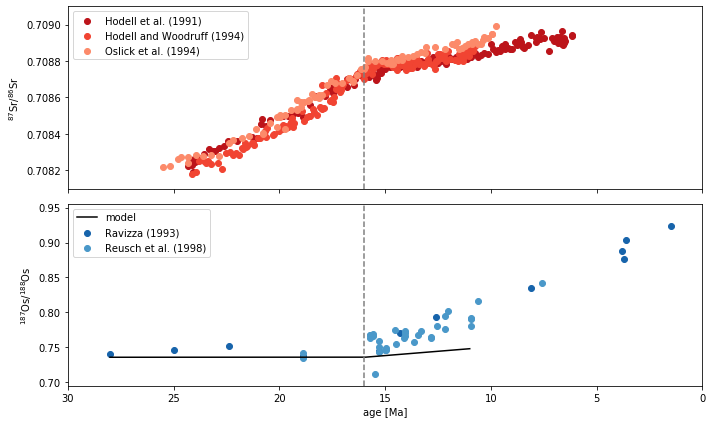

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)

# Sr
Sr_cmap = get_cmap('Reds')

ax[0].scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.8)], label='Hodell et al. (1991)')

ax[0].scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.6)], label='Hodell and Woodruff (1994)')

ax[0].scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

# Os
Os_cmap = get_cmap('Blues')

ax[1].scatter(Ravizza1993_age, Ravizza1993_Os,
              c=[Os_cmap(0.8)], label='Ravizza (1993)')

ax[1].scatter(Reusch1998_age, Reusch1998_Os,
              c=[Os_cmap(0.6)], label='Reusch et al. (1998)')

ax[1].plot(Os_t, Os_R_SW, c='k', label='model')

# prettify
ax[0].axvline(16, ls='--', c='C7')
ax[1].axvline(16, ls='--', c='C7')

ax[0].set_ylim(0.7081, 0.7091)
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].legend()

ax[1].set_ylabel('$^{187}$Os/$^{188}$Os')
ax[1].set_xlabel('age [Ma]')
ax[1].set_xlim(30,0)
ax[1].legend()

fig.tight_layout()
plt.show(fig)